In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

birth_day = 11
n_informative = 1 + birth_day // 2
noise_level = 0.5 * birth_day 

In [ ]:
class TwoLayerMLP:
    def __init__(self, input_size, hidden_size, output_size=1, lr=0.01):
        self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.lr = lr
        
        self.loss_history = []
        self.gradients_history = {'w1': [], 'w2': []}
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.z1 = X @ self.w1 + self.b1  
        self.a1 = self.relu(self.z1)     
        self.z2 = self.a1 @ self.w2 + self.b2  
        return self.z2
    
    def compute_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    
    def backward(self, X, y_true, y_pred):
        n_samples = X.shape[0]
        
        # Градиент Loss по предсказанию
        dL_dz2 = (y_pred - y_true) / n_samples 
        
        # Градиенты для второго слоя
        dL_dw2 = self.a1.T @ dL_dz2  
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)  
        
        # Градиенты для первого слоя
        dL_da1 = dL_dz2 @ self.w2.T  
        dL_dz1 = dL_da1 * self.relu_derivative(self.z1)  
        
        dL_dw1 = X.T @ dL_dz1  
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)  
        
        # Сохраняем нормы градиентов для анализа
        self.gradients_history['w1'].append(np.linalg.norm(dL_dw1))
        self.gradients_history['w2'].append(np.linalg.norm(dL_dw2))
        
        # Обновление весов
        self.w2 -= self.lr * dL_dw2
        self.b2 -= self.lr * dL_db2
        self.w1 -= self.lr * dL_dw1
        self.b1 -= self.lr * dL_db1
        
        return {
            'w1': dL_dw1, 'b1': dL_db1,
            'w2': dL_dw2, 'b2': dL_db2
        }
    
    def train(self, X, y, epochs=100, verbose=False):
        self.loss_history = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            
            self.backward(X, y, y_pred)
            
            if verbose and (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")

In [22]:
def generate_regression_data(n_samples, n_features=50, random_state=42):
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise_level,
        random_state=random_state
    )
    X = np.column_stack([X, np.ones(X.shape[0])])
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    y = y.reshape(-1, 1)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    return X_scaled, y_scaled, scaler_y

datasets = {}
for n_samples in [100, 1000, 10000]:
    X, y, scaler = generate_regression_data(n_samples)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    datasets[n_samples] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'scaler': scaler
    }
    print(f"Dataset n_samples={n_samples}: X.shape={X_train.shape}")

Dataset n_samples=100: X.shape=(80, 51)
Dataset n_samples=1000: X.shape=(800, 51)
Dataset n_samples=10000: X.shape=(8000, 51)


In [ ]:
def run_experiments(n_samples, n_runs=10, epochs=200, hidden_size=20, lr=0.001):
    results = {
        'losses': [],
        'final_losses': [],
        'gradients_w1': [],
        'gradients_w2': []
    }
    
    for run in range(n_runs):
        input_size = datasets[n_samples]['X_train'].shape[1]
        model = TwoLayerMLP(input_size, hidden_size, lr=lr)
        
        model.train(
            datasets[n_samples]['X_train'],
            datasets[n_samples]['y_train'],
            epochs=epochs
        )
        
        results['losses'].append(model.loss_history)
        results['final_losses'].append(model.loss_history[-1])
        results['gradients_w1'].append(model.gradients_history['w1'])
        results['gradients_w2'].append(model.gradients_history['w2'])
        
        print(f"Run {run+1}/{n_runs}, Final Loss: {model.loss_history[-1]:.6f}")
    
    return results

all_results = {}
for n_samples in [100, 1000, 10000]:
    print(f"Запуск экспериментов для n_samples = {n_samples}")
    all_results[n_samples] = run_experiments(n_samples, n_runs=10)

Запуск экспериментов для n_samples = 100
Run 1/10, Final Loss: 1.056946
Run 2/10, Final Loss: 1.108184
Run 3/10, Final Loss: 1.261734
Run 4/10, Final Loss: 1.223902
Run 5/10, Final Loss: 1.205181
Run 6/10, Final Loss: 1.231795
Run 7/10, Final Loss: 1.452838
Run 8/10, Final Loss: 1.612251
Run 9/10, Final Loss: 1.446720
Run 10/10, Final Loss: 1.290702
Запуск экспериментов для n_samples = 1000
Run 1/10, Final Loss: 1.525101
Run 2/10, Final Loss: 1.882502
Run 3/10, Final Loss: 1.632546
Run 4/10, Final Loss: 1.636224
Run 5/10, Final Loss: 1.538166
Run 6/10, Final Loss: 1.427539
Run 7/10, Final Loss: 1.306876
Run 8/10, Final Loss: 1.893884
Run 9/10, Final Loss: 1.846936
Run 10/10, Final Loss: 1.359435
Запуск экспериментов для n_samples = 10000
Run 1/10, Final Loss: 1.675511
Run 2/10, Final Loss: 1.845016
Run 3/10, Final Loss: 1.556566
Run 4/10, Final Loss: 1.130277
Run 5/10, Final Loss: 1.568652
Run 6/10, Final Loss: 1.830756
Run 7/10, Final Loss: 1.357043
Run 8/10, Final Loss: 1.660109
Run 

C:\Users\kkras\AppData\Local\Temp\ipykernel_7556\936463946.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(final_losses, labels=labels)


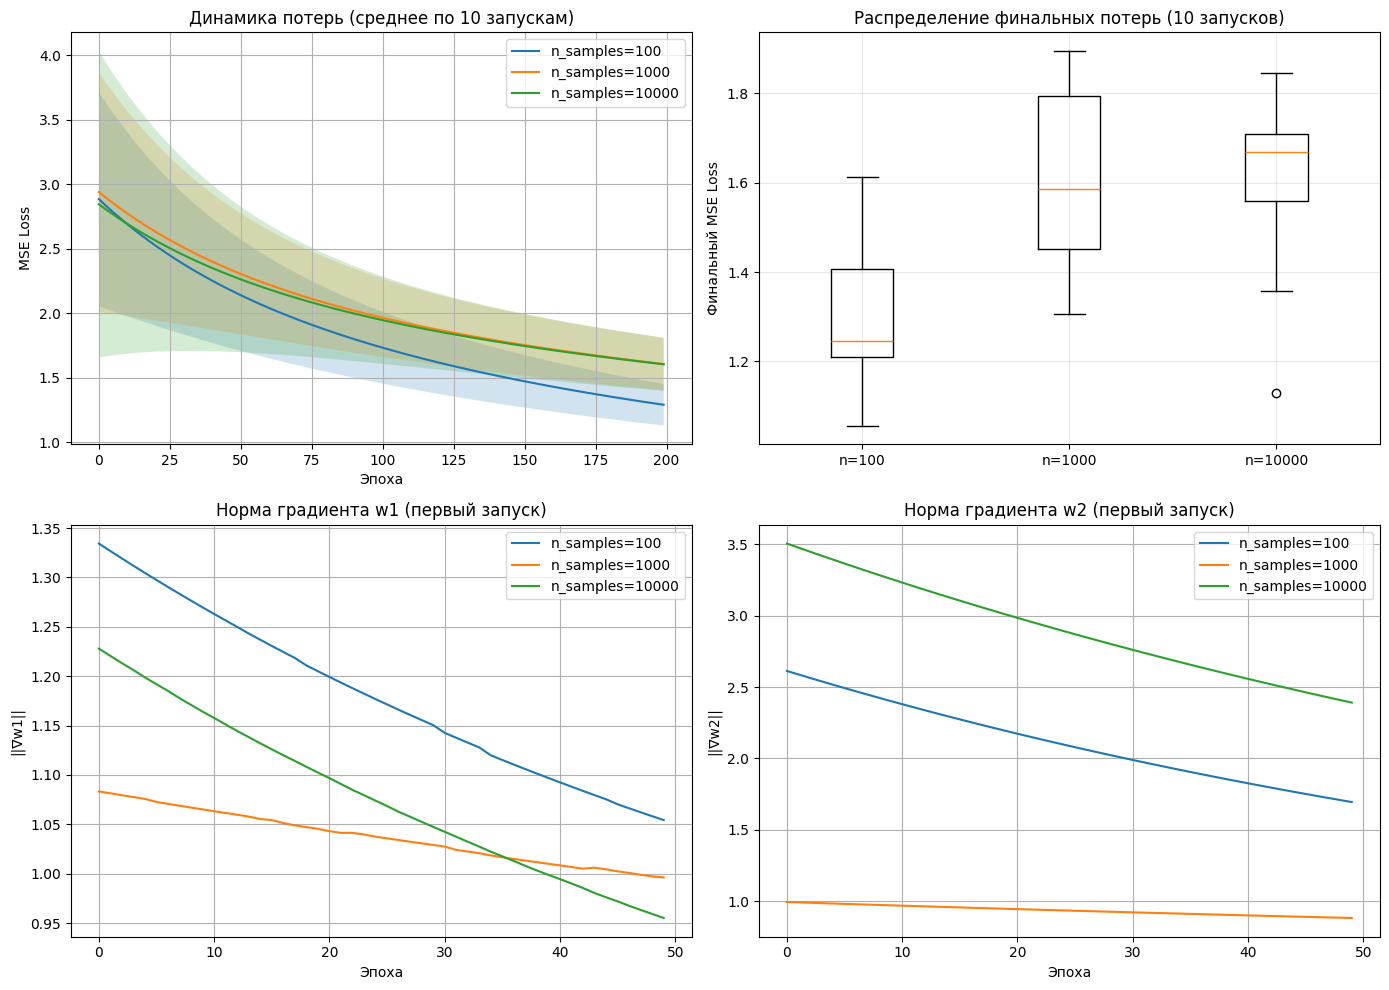


=== Статистика финальных потерь (10 запусков) ===

n_samples = 100:
  Mean: 1.289025
  Std:  0.160635
  Min:  1.056946
  Max:  1.612251

n_samples = 1000:
  Mean: 1.604921
  Std:  0.203040
  Min:  1.306876
  Max:  1.893884

n_samples = 10000:
  Mean: 1.602703
  Std:  0.206413
  Min:  1.130277
  Max:  1.845016


In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].set_title('Динамика потерь (среднее по 10 запускам)')
for n_samples in [100, 1000, 10000]:
    losses = np.array(all_results[n_samples]['losses'])
    mean_loss = losses.mean(axis=0)
    std_loss = losses.std(axis=0)
    epochs = range(len(mean_loss))
    axes[0, 0].plot(epochs, mean_loss, label=f'n_samples={n_samples}')
    axes[0, 0].fill_between(epochs, mean_loss-std_loss, mean_loss+std_loss, alpha=0.2)
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Распределение финальных потерь (10 запусков)')
final_losses = []
labels = []
for n_samples in [100, 1000, 10000]:
    final_losses.append(all_results[n_samples]['final_losses'])
    labels.append(f'n={n_samples}')
axes[0, 1].boxplot(final_losses, labels=labels)
axes[0, 1].set_ylabel('Финальный MSE Loss')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Норма градиента w1 (первый запуск)')
for n_samples in [100, 1000, 10000]:
    gradients = all_results[n_samples]['gradients_w1'][0][:50]  # Первые 50 эпох
    axes[1, 0].plot(range(len(gradients)), gradients, label=f'n_samples={n_samples}')
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('||∇w1||')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].set_title('Норма градиента w2 (первый запуск)')
for n_samples in [100, 1000, 10000]:
    gradients = all_results[n_samples]['gradients_w2'][0][:50]
    axes[1, 1].plot(range(len(gradients)), gradients, label=f'n_samples={n_samples}')
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('||∇w2||')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\n=== Статистика финальных потерь (10 запусков) ===")
for n_samples in [100, 1000, 10000]:
    losses = all_results[n_samples]['final_losses']
    print(f"\nn_samples = {n_samples}:")
    print(f"  Mean: {np.mean(losses):.6f}")
    print(f"  Std:  {np.std(losses):.6f}")
    print(f"  Min:  {np.min(losses):.6f}")
    print(f"  Max:  {np.max(losses):.6f}")

ДЕМОНСТРАЦИЯ VANISHING GRADIENT PROBLEM В RNN

Последовательность длины T=5
  Финальная потеря: 9.9201
  Градиент h[0]: 2.8205e-07
  Градиент h[T-1]: 1.3175e-01
  Отношение: 2.14e-06

Последовательность длины T=10
  Финальная потеря: 0.4921
  Градиент h[0]: 6.3389e-14
  Градиент h[T-1]: 3.4555e-02
  Отношение: 1.83e-12

Последовательность длины T=20
  Финальная потеря: 8.6160
  Градиент h[0]: 9.9287e-27
  Градиент h[T-1]: 1.2169e-01
  Отношение: 8.16e-26

Последовательность длины T=30
  Финальная потеря: 1.3100
  Градиент h[0]: 1.3759e-42
  Градиент h[T-1]: 5.8912e-02
  Отношение: 2.34e-41

Последовательность длины T=50
  Финальная потеря: 0.3081
  Градиент h[0]: 5.5624e-69
  Градиент h[T-1]: 2.1309e-02
  Отношение: 2.61e-67


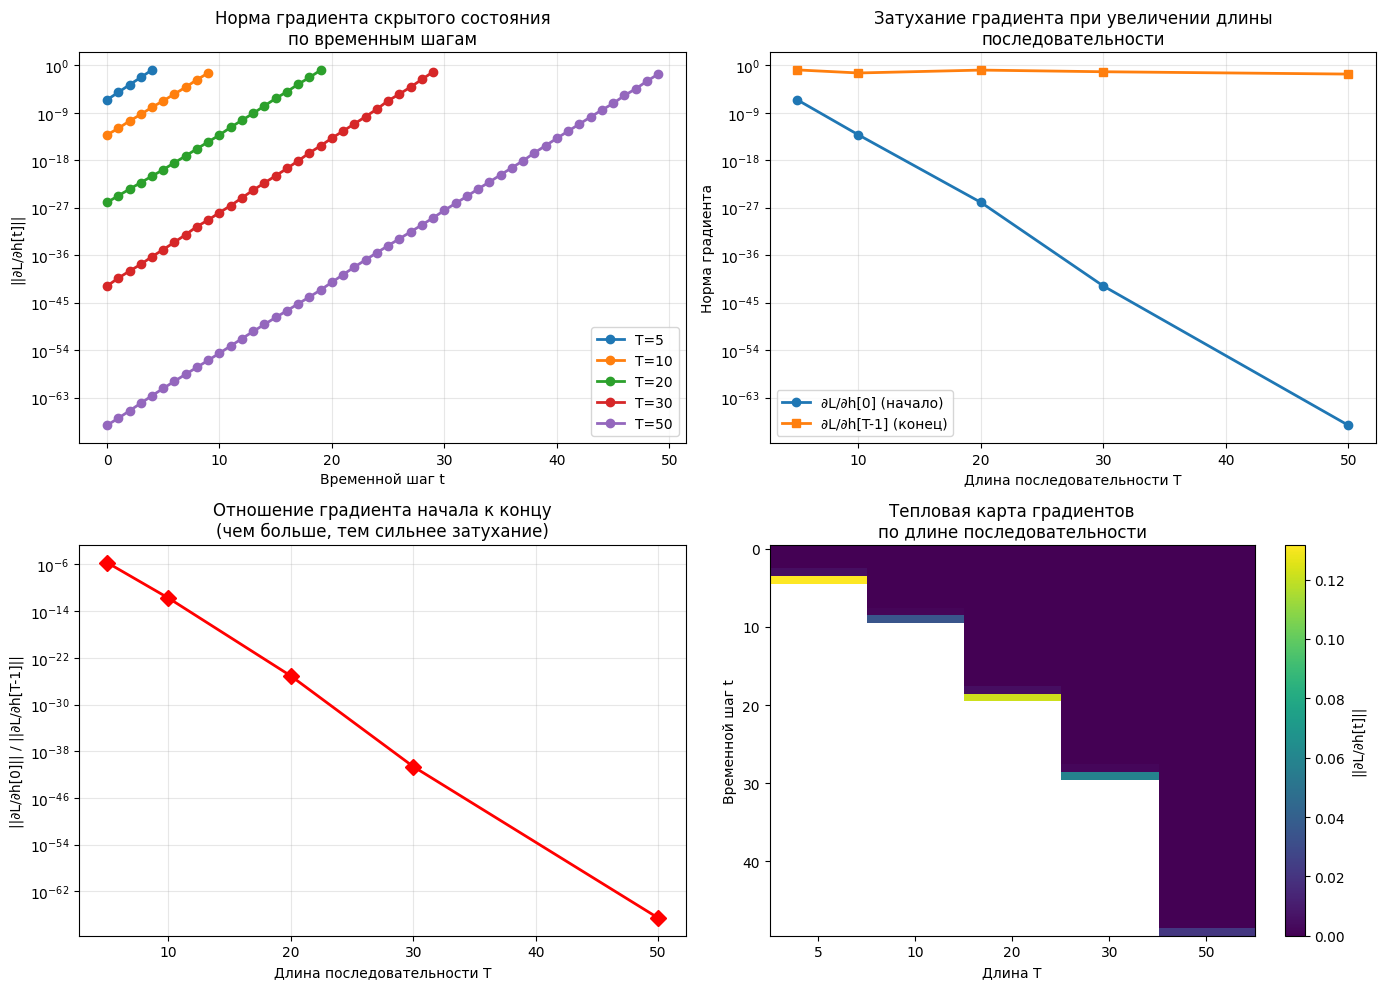

In [25]:
import numpy as np
import matplotlib.pyplot as plt

class ManualRNN:
    def __init__(self, input_size, hidden_size, lr=0.01):
        self.Wxh = np.random.randn(input_size, hidden_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(hidden_size, 1) * 0.01
        self.bh = np.zeros((1, hidden_size))
        self.by = np.zeros((1, 1))
        
        self.lr = lr
        self.hidden_size = hidden_size
        
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    def forward(self, X):
        T = X.shape[0]
        self.x = X
        self.h = {}
        self.z = {}
        
        self.h[-1] = np.zeros((1, self.hidden_size))
        
        for t in range(T):
            self.z[t] = X[t:t+1] @ self.Wxh + self.h[t-1] @ self.Whh + self.bh
            self.h[t] = self.tanh(self.z[t])
        
        # Выход
        y_pred = self.h[T-1] @ self.Why + self.by
        return y_pred
    
    def backward(self, X, y_true, y_pred):
        T = X.shape[0]
        
        # Градиенты параметров
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        
        # Градиент выхода
        dy = (y_pred - y_true)
        
        # Градиент для Why и by
        dWhy = self.h[T-1].T @ dy
        dby = dy
        
        # Градиент скрытого состояния на последнем шаге
        dh = dy @ self.Why.T
        
        # Список для хранения градиентов по времени
        self.gradients_norms = {'Whh': [], 'Wxh': [], 'h': []}
        
        for t in reversed(range(T)):
            # Градиент до активации
            dz = dh * self.tanh_derivative(self.z[t])
            
            # Сохраняем нормы градиентов для анализа
            self.gradients_norms['Whh'].insert(0, np.linalg.norm(dz @ self.Whh.T))
            self.gradients_norms['Wxh'].insert(0, np.linalg.norm(dz @ self.Wxh.T))
            self.gradients_norms['h'].insert(0, np.linalg.norm(dh))
            
            # Градиенты весов
            dWxh += X[t:t+1].T @ dz
            dWhh += self.h[t-1].T @ dz
            dbh += dz
            
            # Градиент для предыдущего скрытого состояния
            if t > 0:
                dh = dz @ self.Whh.T
        
        # Обновление весов
        self.Wxh -= self.lr * dWxh
        self.Whh -= self.lr * dWhh
        self.Why -= self.lr * dWhy
        self.bh -= self.lr * dbh
        self.by -= self.lr * dby
        
        return dWxh, dWhh, dWhy, dbh, dby

def generate_sequence_data(T, input_size=10, hidden_pattern=True):
    X = np.random.randn(T, input_size) * 0.5
    
    if hidden_pattern:
        y = np.sum(X[0, :5]) + np.sum(X[T//2, :5]) + np.random.randn() * 0.1
    else:
        y = np.sum(X[-1, :5]) + np.random.randn() * 0.1
    
    return X, y.reshape(1, 1)

def demonstrate_rnn_vanishing_gradient():
    print("ДЕМОНСТРАЦИЯ VANISHING GRADIENT PROBLEM В RNN")
    
    input_size = 10
    hidden_size = 20
    lr = 0.01
    
    sequence_lengths = [5, 10, 20, 30, 50]
    
    results = {}
    
    for T in sequence_lengths:
        print(f"\nПоследовательность длины T={T}")
        
        rnn = ManualRNN(input_size, hidden_size, lr=lr)
        
        X, y = generate_sequence_data(T, input_size)
        
        y_pred = rnn.forward(X)
        rnn.backward(X, y, y_pred)
        
        results[T] = {
            'gradients': rnn.gradients_norms,
            'final_loss': np.mean((y_pred - y)**2)
        }
        
        print(f"  Финальная потеря: {results[T]['final_loss']:.4f}")
        print(f"  Градиент h[0]: {rnn.gradients_norms['h'][0]:.4e}")
        print(f"  Градиент h[T-1]: {rnn.gradients_norms['h'][-1]:.4e}")
        ratio = rnn.gradients_norms['h'][0] / rnn.gradients_norms['h'][-1]
        print(f"  Отношение: {ratio:.2e}")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    ax1 = axes[0, 0]
    for T in sequence_lengths:
        time_steps = range(T)
        grad_norms = results[T]['gradients']['h']
        ax1.plot(time_steps, grad_norms, marker='o', label=f'T={T}', linewidth=2)
    ax1.set_yscale('log')
    ax1.set_title('Норма градиента скрытого состояния\nпо временным шагам')
    ax1.set_xlabel('Временной шаг t')
    ax1.set_ylabel('||∂L/∂h[t]||')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    T_values = list(results.keys())
    grad_start = [results[T]['gradients']['h'][0] for T in T_values]
    grad_end = [results[T]['gradients']['h'][-1] for T in T_values]
    
    ax2.plot(T_values, grad_start, marker='o', linewidth=2, label='∂L/∂h[0] (начало)')
    ax2.plot(T_values, grad_end, marker='s', linewidth=2, label='∂L/∂h[T-1] (конец)')
    ax2.set_yscale('log')
    ax2.set_title('Затухание градиента при увеличении длины\nпоследовательности')
    ax2.set_xlabel('Длина последовательности T')
    ax2.set_ylabel('Норма градиента')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3 = axes[1, 0]
    ratios = [grad_start[i]/grad_end[i] for i in range(len(T_values))]
    ax3.plot(T_values, ratios, marker='D', linewidth=2, color='red', markersize=8)
    ax3.set_yscale('log')
    ax3.set_title('Отношение градиента начала к концу\n(чем больше, тем сильнее затухание)')
    ax3.set_xlabel('Длина последовательности T')
    ax3.set_ylabel('||∂L/∂h[0]|| / ||∂L/∂h[T-1]||')
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    max_T = max(sequence_lengths)
    grad_matrix = np.full((max_T, len(sequence_lengths)), np.nan)
    
    for i, T in enumerate(sequence_lengths):
        grads = results[T]['gradients']['h']
        grad_matrix[:T, i] = grads
    
    im = ax4.imshow(grad_matrix, cmap='viridis', aspect='auto')
    ax4.set_title('Тепловая карта градиентов\nпо длине последовательности')
    ax4.set_xlabel('Длина T')
    ax4.set_ylabel('Временной шаг t')
    ax4.set_xticks(range(len(sequence_lengths)))
    ax4.set_xticklabels(sequence_lengths)
    plt.colorbar(im, ax=ax4, label='||∂L/∂h[t]||')
    
    plt.tight_layout()
    plt.show()
    
    return results

results = demonstrate_rnn_vanishing_gradient()